In [1]:
import numpy as np
from gensim import corpora
from gensim import models
from gensim.parsing.preprocessing import STOPWORDS

from collections import Counter
import re
from sklearn import datasets
import nltk
#import pyLDAvis.gensim
import pandas as pd
import os
import random
import warnings
import seaborn
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/Users/wuchengke/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def tokenize(text, stopwords): # tokenize + stopwords removal
    text = text.lower().strip()
    words = re.sub('\W', ' ', text).split() # \W 匹配任何非单词字符
    words = [re.sub('\\s+', ' ', w) for w in words]
    words = [w for w in words if w not in stopwords]
    return words

def save_model(model, name, root, model_dir='models/'):
    save_path = os.path.join(root, model_dir)
    os.chdir(save_path)
    model.save(name + '.model')
    os.chdir('..')

def load_model(name, root, model_dir='models/'):
    model_path = os.path.join(root, model_dir)
    os.chdir(model_path)
    name = name + '.model'
    model_path = os.path.join(model_path, name)
    model = models.ldamodel.LdaModel.load(model_path)
    os.chdir('..')
    return model

def tolower(text):
    return str(text).lower()

def sub_letters(text):
    text = text.strip()
    text = re.sub('\W', ' ', text)
    text = re.sub('\\s+', ' ', text)
    return text

def train_model(train_corpus, topic_len, id2word_dict, passes, iters, threshold=None, num_threshold=3):
    model = models.ldamodel.LdaModel(train_corpus, num_topics=topic_len, id2word=id2word_dict, passes=passes, iterations=iters)
    topics = model.print_topics(topic_len)
    
    if not threshold==None:
        temp_probs = []
        num_err_topics = 0
        
        for t in topics:
            prob = float(t[1].split('+')[0][0:5]) # get the maximum probability of each topic, i.e., the first probability
            temp_probs.append(prob)
            if prob < threshold:
                num_err_topics += 1
        
        min_prob = np.min(temp_probs)
        #print(min_prob, num_err_topics)
        if min_prob >= threshold or num_err_topics <= num_threshold:
            return True, topics, model, (min_prob, num_err_topics)
        else:
            return False, topics, model, (min_prob, num_err_topics)
    else:
        return True, topics, model

def generate_testing_terms(size, high, id2word_dict): # high: the maximum number of terms in the dictionary; size: the number of testing samples
    testing_terms = []
    while(len(testing_terms) < size):
        idx = random.randint(0, high)
        if id2word_dict[idx] in testing_terms:
            continue
        temp_term = id2word_dict[idx]
        #print(temp_term)
        if 'contains' in temp_term:
            continue
        testing_terms.append(temp_term)
    return testing_terms

def tagging(term):
    if not 'covers' in term:
        tag = term.split(' ')[-1]
        stri = ' '
        term = stri.join(term.split(' ')[:-1])
        return (term, tag)
    else:
        return (term, None)

def extra_same_elem(l1, l2):
    set1 = set(l1)
    set2 = set(l2)
    iset = set1.intersection(set2)
    return(list(iset))

def extra_dif_elem(l1, l2):
    same_elem = extra_same_elem(l1, l2)
    dif_elem = [x for x in (l1 + l2) if x not in same_elem]
    return dif_elem

def find_duplicates(ls):
    dic = dict(Counter(ls))
    duplicates = [key for key, value in dic.items() if value>1]
    return duplicates

def semantic_data_enrich(df):
    # semantic enriching
    all_lst = []
    for i, row in df.iterrows():
        row = row.dropna().values
        terms = list(row[0 : -1])
        terms = list(map(tagging, list(map(sub_letters, list(map(tolower, terms))))))
        
        spatials = row[-1].split(';') # get spatial relation list
        spatial_tags = [sp.split('contains')[0] for sp in spatials]
        
        out_terms = [t[0] for t in terms]
        print('row', row)
        final_out_terms = []
        for ot in out_terms:
            if not 'covers'in ot:
                for st in spatial_tags:                    
                    final_out_terms.append(ot + 'SPTAG' + st)
            else:
                final_out_terms.append(ot)
        print(final_out_terms)
        
        c_list = []
        mc_list = []
        pm_list = []
        other_list = []
        add_list = []
        for t in terms:
            if t[-1]=='mc':
                mc_list.append(t[0])
            elif t[-1]=='c':
                c_list.append(t[0])
            elif t[-1]=='pm':
                pm_list.append(t[0])
            else:
                other_list.append(t[0])
   
        for sp in spatials:
            for c in c_list:
                add = sp + 'SPLINK' + c #+ ' + ' + st # spatial contains cxx + spatial tag
                add_list.append(add)
        
        all_c = '; '.join(c_list)
        for mc in mc_list:
            if len(c_list)>0:
                for c in c_list:
                    add = mc + 'CONNECTS' + c
                    add_list.append(add)
            for sp in spatials:
                add = sp + 'SPLINK' + mc #+ ' + ' + st
                add_list.append(add) # spatial contains mcxx + spatial tag

        for pm in pm_list:
            for c in c_list:
                add = pm + 'PAINTON' + c #+ ' + ' + st
                add_list.append(add)
        #print(str(i), '\t', len(add_list + final_out_terms))
        print(add_list + final_out_terms)
        print()
        all_lst.append(add_list + final_out_terms)
        
    return pd.DataFrame(all_lst)

def data_expand(df, hsize=0, vsize=0, prob=0.2):
    # horizontally expand
    for i, row in df.iterrows(): # expand each row
        temp_row = list(row.dropna().values)
        ls_len = len(temp_row)
        for j in range(0, hsize - ls_len): # expand each row by 'hsize'
            randx = np.random.randint(0, ls_len)
            rand_term = temp_row[randx] # get a random index of the original df columns
            temp_row.append(rand_term)
            #print(randx, ' ', rand_term)
        print('horizontally expand results: origin: ', ls_len, 'later: ', len(temp_row))
    
    # vertically expand
    add_tags = []
    add_rows = []
    for i in range(0, vsize):
        randx = np.random.randint(1, df.shape[0]) # assume the first column is the label
        temp_row = list(df.iloc[randx].dropna().values)
        limit = int(np.floor(len(temp_row) * prob))
        # print(temp_row,'  ',len(temp_row))
        
        if np.random.randint(0, 10)>=5:
            add_tags.append('drop')
            for i in range(0, limit):
                temp_row.pop(np.random.randint(0, len(temp_row)))
        else:
            add_tags.append('add')
            for i in range(0, limit):
                temp_row.append(temp_row[np.random.randint(0, len(temp_row))])
        add_rows.append(temp_row)
    
    temp_df = pd.DataFrame(add_rows)
    df = pd.concat([df, temp_df], axis=0)
    drop_mode = len([a for a in add_tags if a=='drop'])
    add_mode = len([a for a in add_tags if a=='add'])
    print('in the expansion, {} columns are added, {} rows are added, while among the added rows {} drop-mode and {} add-mode.'.format(hsize, vsize, drop_mode, add_mode))
    return df, add_tags

def plot_confusion_matrix(cm, save_path, classes=None, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title==None:
        title = 'Confusion matrix of LDA mapping'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, dpi=400) 
    plt.show()

In [3]:
root = os.getcwd()
print('current base file: ', root)
work_data = os.path.join(root, 'data/data_separated_23.csv')

stopwords = STOPWORDS
enhance = False
tf_idf = False
topic_len = 23
h_size = 100 # 按列拓展数据
v_size = 1000 # 按行拓展数据
prob = 0

print('currently there are {} tasks'.format(topic_len))
data_work_df = pd.read_csv(work_data, header=None)
if enhance == True:
    data_work_df = semantic_data_enrich(data_work_df)

train_df, _ = data_expand(data_work_df, hsize=h_size, vsize=v_size, prob=prob)

train_term_list = []
for i, row in train_df.iterrows():
    temp = list(row.dropna().values)
    train_term_list.append(temp)

current base file:  /Users/wuchengke/Documents/Other Study/Jupyter/LDA
currently there are 23 tasks
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  16 later:  100
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  18 later:  100
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  20 later:  100
horizontally expand results: origin:  18 later:  100
horizontally expand results: origin:  20 later:  100
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  20 later:  100
horizontally expand results: origin:  22 later:  100
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  21 later:  100
horizontally expand results: origin:  17 later:  100
horizontally expand results: origin:  19 later:  100
horizontally expand results: origin:  21 later:  100
horizontally expand results: origin:  20 later:  100

in the expansion, 100 columns are added, 1000 rows are added, while among the added rows 479 drop-mode and 521 add-mode.


In [7]:
id2word_dict = corpora.Dictionary(train_term_list) # id -> word (after pre-processing)
print('原始word2id词典大小: ', len(id2word_dict))
#id2word_dict.filter_extremes(no_below = 20, no_above = 0.1)
#print('经过频次过滤后的word2id词典大小: ', len(id2word_dict))

# generate word2id dic
word2id_dict = {}
for k, v in id2word_dict.items():
    word2id_dict.update({v : k})
all_terms = list(word2id_dict.keys()) # 记录所有的term 初步 testing的时候从这个里面随机选
    
train_corpus = []
for pdoc in train_term_list:
    # doc2bow输出结果是a list of tuples 每个tuple是这个文档中每个词（按顺序）在该文档中的频次
    tb = id2word_dict.doc2bow(pdoc)
    train_corpus.append(tb)

原始word2id词典大小:  178


In [9]:
# trian LDA model
import time
if tf_idf==True:
    tf_idf = models.TfidfModel(train_corpus)
    train_corpus = tf_idf[train_corpus]

count = 0
#while(True):
#    start = time.time()
#    flag, topics, lda_model, info = train_model(train_corpus, topic_len, id2word_dict, 10, 1000, 0.08, 0) # passes, iters, threshold
#    count = count + 1
#    end = time.time()
#    print('current count: {}, min prob: {}, err_topics {}, current run: {}s, '.format(count, info[0], info[1], np.round(end - start, 2)))
#    if flag==True or count==1000:
#        break;

#print('current preplexity: ', lda_model.log_perplexity(train_corpus), '\n') 
lda_model.print_topics(35)

[(0,
  '0.185*"condiuts and accessories" + 0.185*"mep conduit" + 0.185*"conduit" + 0.185*"flexible conduit" + 0.138*"upvc conduits" + 0.046*"flexible conduit belongs to mep system" + 0.046*"upvc conduits and fittings" + 0.000*"knauf frp board" + 0.000*"gypsum board" + 0.000*"gemtree frp board"'),
 (1,
  '0.179*"shear stud" + 0.179*"ceiling system contains steel ceiling beam" + 0.179*"ceiling system contains shear stud" + 0.179*"ceiling system contains ceiling panel" + 0.179*"ceiling panel" + 0.060*"steel ceiling beam" + 0.001*"corner casting" + 0.001*"steel angle" + 0.001*"steel column" + 0.001*"overhead door closer"'),
 (2,
  '0.203*"bar chair" + 0.203*"steel reinforcement bar" + 0.203*"reinforcement bar" + 0.203*"rebar" + 0.102*"tie wire" + 0.051*"spacer" + 0.000*"knauf frp board" + 0.000*"gemtree frp board" + 0.000*"gypsum board" + 0.000*"cement board"'),
 (3,
  '0.339*"concrete mixture" + 0.339*"concrete" + 0.170*"non shrink grout" + 0.113*"concrete addings" + 0.000*"composite floo

In [12]:
true_topics = {0:'3d assembly', 1:'install window and door', 2:'welding', 3:'install window and door frame', 4:'rebar fix',
              5:'2d assembly', 6:'board pretreatment', 7:'paint structure', 8:'wall finishing', 9:'concreting'}


In [6]:
true_topics = {0:'installing MEP at wall', 1:'installing ceiling stud', 2:'rebar fixing', 3:'pouring concrete',
              4:'layer and coat painting', 5:'3D assembly', 6:'installing door and window frame', 7:'installing cabinet',
              8:'intalling gypsum board at wall', 9:'installing sprinkler pipes', 10:'installing vinyl and skirting',
              11:'installing door and window ironmongery', 12:'electrical cable wiring', 13:'2D panel assembly',
              14:'board pretreatment and punching', 15:'installing MEP trunking at ceiling', 16:'Butt and fillet weld',
              17:'painting structure member', 18:'rockwool in-fill at ceiling', 19:'installing stud at wall', 20:'rockwool in-fill at wall',
              21:'installing window AC', 22:'installing lighting'}


In [7]:
vis = pyLDAvis.gensim.prepare(lda_model, train_corpus, id2word_dict)
pyLDAvis.display(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [28/Jul/2021 15:21:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2021 15:21:04] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2021 15:21:04] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2021 15:21:04] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


In [3]:
# 保存模型
#save_model(btm, 'work_0729', root)


### 测试模型

In [53]:
# test new data -- predict topic of a new doc
def model_test(terms, lda_model, stopwords, detail=False):
    if detail==True:
        terms = [tokenize(term, stopwords) for term in terms]
    else:
        for t in range(len(terms)):
            if isinstance(terms[t], list):
                for j in range(len(terms[t])):
                    pass
                    #terms[t][j] = tolower(terms[t][j])
                    #terms[t][j] = sub_letters(terms[t][j])
            else:
                pass
                #terms[t] = tolower(terms[t])
                #terms[t] = sub_letters(terms[t])
    
    new_terms = terms
    doc_pred_list = []
    tp_list = []
    all_probs = []
    for terms in new_terms:
        if isinstance(terms, list):
            new_doc_bow = id2word_dict.doc2bow(terms)
        else:
            new_doc_bow = id2word_dict.doc2bow([terms])
        lda_pred = lda_model[new_doc_bow]
        doc_pred_list.append(lda_pred)
    
    for pred in doc_pred_list:
        prob_list = []
        for tp in pred:
            prob_list.append(tp[1]) 
        all_probs.append(prob_list)
        candi_tp_idx = np.argmax(prob_list)
        candi_tp = pred[candi_tp_idx]
        tp_list.append(candi_tp)

    return list(zip(tp_list, new_terms)), all_probs

In [15]:
new_doc_bow = id2word_dict.doc2bow(['concrete mixture'])
lda_model[new_doc_bow]

[(0, 0.04347826),
 (1, 0.04347826),
 (2, 0.04347826),
 (3, 0.04347826),
 (4, 0.04347826),
 (5, 0.04347826),
 (6, 0.04347826),
 (7, 0.04347826),
 (8, 0.04347826),
 (9, 0.04347826),
 (10, 0.04347826),
 (11, 0.04347826),
 (12, 0.04347826),
 (13, 0.04347826),
 (14, 0.04347826),
 (15, 0.04347826),
 (16, 0.04347826),
 (17, 0.04347826),
 (18, 0.04347826),
 (19, 0.04347826),
 (20, 0.04347826),
 (21, 0.04347826),
 (22, 0.04347826)]

In [49]:
def acc_demo(testing_terms, true_labels, lda_model, stopwords, num=100):
    count = 0
    acc_list = []
    while(count < num):
        preds, all_probs = model_test(testing_terms, lda_model, stopwords)
        pred_idx = [p[0][0] for p in preds]

        assert len(preds) == len(true_labels)
        correct = 0
        for i in range(0, len(pred_idx)):
            if pred_idx[i]==true_labels[i]:
                correct += 1
            else:
                #print('wrong prediction product idx {}, {}: true label -- {}, prediction -- {}'.format(i, testing_terms[i], true_topics[true_labels[i]], true_topics[pred_idx[i]]))
                pass
        acc = correct/len(pred_idx)
        acc_list.append(acc)
        count += 1
    return pred_idx, acc_list


In [5]:
# 装载模型 & 正确标签
lda_model = load_model('work_3', root)

### 加载testing数据 no enhancement

In [71]:
testing_terms.index('Gypsum Board')

26

In [72]:
true_labels[26]

8

In [84]:
test_sample_size = 50
#testing_terms = generate_testing_terms(test_sample_size, len(id2word_dict)-1, id2word_dict)
#testing_terms.extend([''])
#true_labels = [8,6,0,6,2,0,0,0,1,3,7,9,1,4,5,9,9,7,1,6,3,4,8,1,0,7,8,6,0,8,0,3,9,7,3,0,1,2,4,5,3,4,0,2,1,0,4,1,7,8]

#test_df = pd.DataFrame({'task_name':testing_terms, 'true_label':true_labels})
#test_df.to_csv('./testing_df2.csv')

testing_terms = list(pd.read_csv('./testing_df2.csv')['task_name'].values)
true_labels = list(pd.read_csv('./testing_df2.csv')['true_label'].values)

# for 23 tasks: wall panel - 19, steel ceiling beam - 5, ceiling panel -1, gemtree frp board - 14, promatect hboard-20, rockwool - 18
# for 10 tasks: gypsum board -8, shaer stud -0

In [85]:
pred_idx_last, acc_list1 = acc_demo(testing_terms, true_labels, lda_model, stopwords, num=100)
acc_list1[:10]

[0.9006024096385542,
 0.9006024096385542,
 0.9006024096385542,
 0.9066265060240963,
 0.8975903614457831,
 0.9006024096385542,
 0.9006024096385542,
 0.9036144578313253,
 0.9006024096385542,
 0.9096385542168675]

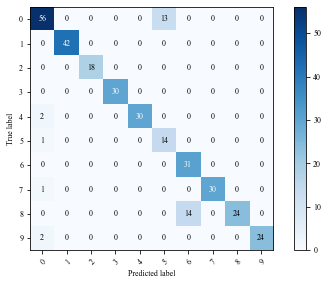

In [86]:
cm = confusion_matrix(true_labels, pred_idx_last) # para1 - true, para2 - preds
fig_path = os.path.join(root, 'confu_mt_10_1.jpg')
plot_confusion_matrix(cm, fig_path)

### 加载testing数据 enhanced

In [127]:
testing_terms2 = list(pd.read_csv('./testing_df3.csv')['task_name'].values)
for i in range(len(testing_terms2)):
    if ',' in testing_terms2[i]:
        x = testing_terms2[i]
        testing_terms2[i] = x.split(',')
        
true_labels2 = list(pd.read_csv('./testing_df3.csv')['true_label'].values)

In [128]:
pred_idx_last2, acc_list2 = acc_demo(testing_terms2, true_labels2, lda_model, stopwords, num=100)
acc_list2[:10]

[0.9386503067484663,
 0.941717791411043,
 0.9386503067484663,
 0.9355828220858896,
 0.9386503067484663,
 0.9478527607361963,
 0.941717791411043,
 0.941717791411043,
 0.9386503067484663,
 0.9355828220858896]

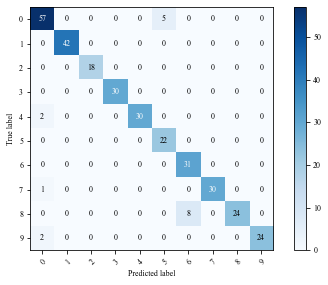

In [129]:
cm2 = confusion_matrix(true_labels2, pred_idx_last2)
fig_path2 = os.path.join(root, 'confu_mt_10_2.jpg')
plot_confusion_matrix(cm2, fig_path2)

In [130]:
print(np.mean(acc_list1))
print(np.mean(acc_list2))

0.903222891566265
0.9397546012269938


In [131]:
total_acc = acc_list1 + acc_list2
mode = ['not enhanced', 'enhanced']
modes = [val for val in mode for i in range(100)]

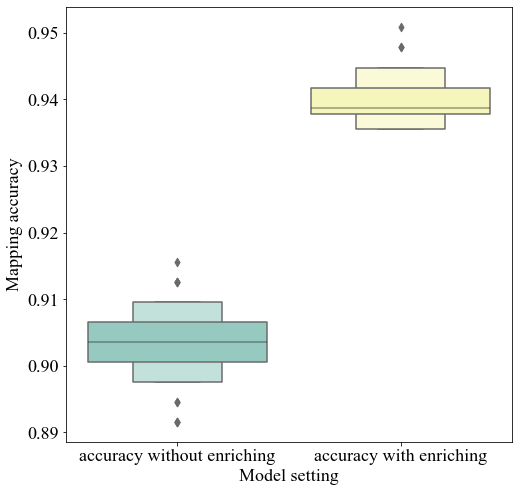

In [132]:
box_df2 = pd.DataFrame({'accuracy without enriching':acc_list1, 'accuracy with enriching':acc_list2})

plt.figure(figsize = (8,8))
seaborn.boxenplot(data=box_df2, orient='v', palette='Set3')
plt.xlabel('Model setting', fontsize=18)
plt.ylabel('Mapping accuracy', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig_path3 = os.path.join(root, 'box_10.jpg')
plt.savefig(fig_path3, dpi=400) 
plt.show()

### 使用Ceiling Panel展示效果

In [18]:
def compute_stability(term, num=100):
    count = 0
    tasks = list(np.zeros((topic_len)).astype(int))
    while count < num:
        new_doc_bow = id2word_dict.doc2bow([term])
        lda_pred = lda_model[new_doc_bow]
        pred_idx = np.argmax([x[1] for x in lda_pred]) # e.g., 4
        #print(pred_idx)
        tasks[pred_idx] += 1 # counting
        count += 1    
    return tasks
    

In [19]:
#fig_path = os.path.join(root, 'bar_demo1.png')  # promatect hboard
#fig_path2 = os.path.join(root, 'bar_demo2.png') # ceiling panel
#fig_path3 = os.path.join(root, 'bar_demo3.png') # electrode
fig_path4 = os.path.join(root, 'bar.jpg') # steel ceiling beam

In [20]:
task_counts_1 = compute_stability('promatect hboard')
task_counts_2 = compute_stability('ceiling panel')
task_counts_3 = compute_stability('electrode')
task_counts_4 = compute_stability('steel ceiling beam')

<Figure size 4608x4608 with 0 Axes>

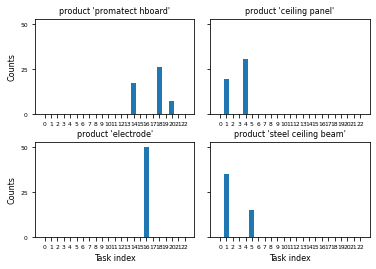

In [23]:
plt.figure(figsize = (64, 64))
fig, ax = plt.subplots(2, 2, sharey=True) # 2 rows and 2 columns
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

xx = [str(i) for i in range(23)]
ax[0,0].set_xticklabels(xx, fontsize=6)
ax[0,0].set_yticklabels([0,25,50,75,100], fontsize=6)
ax[0,0].bar(xx, task_counts_1, width=0.8)
ax[0,0].set_title('product \'' + 'promatect hboard' + '\'', fontsize=8) 
ax[0,0].set_ylabel('Counts', fontsize=8)

ax[0,1].set_xticklabels(xx, fontsize=6)
ax[0,1].set_yticklabels([0,25,50,75,100], fontsize=6)
ax[0,1].bar(xx, task_counts_2, width=0.8)
ax[0,1].set_title('product \'' + 'ceiling panel' + '\'', fontsize=8) 

ax[1,0].set_xticklabels(xx, fontsize=6)
ax[1,0].set_yticklabels([0,25,50,75,100], fontsize=6)
ax[1,0].bar(xx, task_counts_3, width=0.8)
ax[1,0].set_title('product \'' + 'electrode' + '\'', fontsize=8) 
ax[1,0].set_ylabel('Counts', fontsize=8)
ax[1,0].set_xlabel('Task index', fontsize=8)

ax[1,1].set_xticklabels(xx, fontsize=6)
ax[1,1].set_yticklabels([0,25,50,75,100], fontsize=6)
ax[1,1].bar(xx, task_counts_4, width=0.8)
ax[1,1].set_title('product \'' + 'steel ceiling beam' + '\'', fontsize=8)
ax[1,1].set_xlabel('Task index', fontsize=8)

#plt.savefig(fig_path4, dpi=400) 
plt.show()

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
#from biterm.utility import vec_to_biterms
#from biterm.btm import oBTM
#from biterm.utility import vec_to_biterms, topic_summuary
#
#texts = open('./data/train_df.txt').read().splitlines()
#
#vec = CountVectorizer()
#x = vec.fit_transform(texts).toarray()
#print(x.shape)
#
#vocab = np.array(vec.get_feature_names())
#vocab
#
#biterms = vec_to_biterms(x)
#btm = oBTM(num_topics=33, V=vocab)
#topics = btm.fit_transform(biterms, iterations=100)
#
#summary = topic_summuary(btm.phi_wz.T, x, vocab, 10)
#top_words = summary['top_words']
#for tw in top_words:
#    for w in tw:
#        print(w.replace('uu', ' '))
#    print()

#file = open('./data/train_df.txt', 'w')
#for lt in train_term_list:
#    for l in lt:
#        file.write(l)
#        file.write(' ')
#    file.write('.\n')
#file.close()

In [ ]:
testing_terms[0]='Installation of gypsum board at wall surface'
testing_terms[1]='Promatect HBoard'
testing_terms[2]='2D panel'
testing_terms[3]='Lysaght Bondek'
testing_terms[4]='Electrode'
testing_terms[5]='Steel Column'
testing_terms[6]='Steel floor beam'
testing_terms[7]='Steel ceiling beam'
testing_terms[8]='Glass Panel'
testing_terms[9]='Aluminium Cladding'
testing_terms[10]='Apply fire paint at strucutral member'
testing_terms[11]='Concrete addings'
testing_terms[12]='Door ironmongery and windows installation'
testing_terms[13]='Rebar Fixing'
testing_terms[14]='Composite floor slab'
testing_terms[15]='Pouring Concrete'
testing_terms[16]='Non-shrink Grout'
testing_terms[17]='Firecut paint'
testing_terms[18]='Latches'
testing_terms[19]='Gemtree FRP Board'
testing_terms[20]='Door and window frame installation'
testing_terms[21]='Steel Reinforcement Bar'
testing_terms[22]='Laminates'
testing_terms[23]='FRP Timber Door'
testing_terms[24]='3D assembly'
testing_terms[25]='Firecut FM-900 paint'
testing_terms[26]='Gypsum Board'
testing_terms[27]='Knauf FRP Board'
testing_terms[28]='Steel Angle'
testing_terms[29]='Laminate for wall finsishes'
testing_terms[30]='CandleLoc System'
testing_terms[31]='Overhead Door Closer'
testing_terms[32]='Concrete mixture'
testing_terms[33]='3D steel frame'
testing_terms[34]='Door threshold'
testing_terms[35]='Steel Purlins'
testing_terms[36]='Door Ironmongery'
testing_terms[37]='Welding Electrode'
testing_terms[38]='Reinforcement Bar'
testing_terms[39]='Corrugated profile'
testing_terms[40]='Hardwood Solid Core Flush Doors'
testing_terms[41]='Tie Wire'
testing_terms[42]='Shear stud'
testing_terms[43]='Butt weld and fillet weld'
testing_terms[44]='Aluminium Window'
testing_terms[45]='Corner Casting'
testing_terms[46]='Spacer'
testing_terms[47]='Hinge'
testing_terms[48]='Fire protection paint'
testing_terms[49]='Finishings'
